## Predstavenie datasetu:
* Merania spotreby el. energie jednej domacnosti pocas doby styroch rokov.
* Su v nom udaje o spotrebe energie za kazdu uplynutu minutu.
* Modalita dat je time series
* Jeden zaznam je pre uplunulu minutu spriemerovane merania: spotreba aktivnej energie celej domacnosti, 
spotreba reaktivnej energie celej domacnosti, napatie, intenzita domacnosti a spotreba v3och roznych castiach domu


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [4]:

data = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'date':['Date','Time']},
                infer_datetime_format=True, na_values=['nan','?'])

In [5]:
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


<AxesSubplot:>

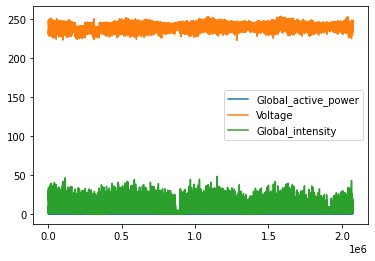

In [7]:
data[[ "Voltage", "Global_intensity"]].plot()

<AxesSubplot:>

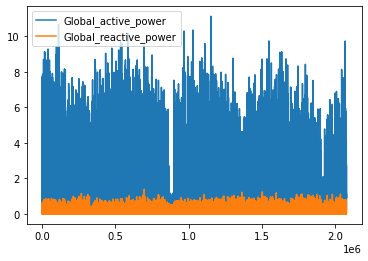

In [8]:
data[["Global_active_power", "Global_reactive_power"]].plot()

Kolko NaN hodnot:

In [9]:
data.isna().sum()

date                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Korelacia dat:

In [10]:
data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000
